### Cryptocurrency Arbitrage Detection Program
### By: Adrian Chavez-Loya

This program utilizes the CoinGecko API to fetch real-time exchange rates between selected cryptocurrencies and USD. It builds a directed graph with USD as the central currency node, connecting to each cryptocurrency with edges representing exchange rates. The primary goal is to analyze potential arbitrage opportunities by examining forward and reverse paths between different cryptocurrencies.

#### Key Components:
1. **Data Fetching**: Retrieves live exchange rates from the CoinGecko API in USD for specified cryptocurrencies.
2. **Graph Construction**: Builds a directed graph with each cryptocurrency as a node and exchange rates as weighted edges.
3. **Path Analysis**: Analyzes possible paths within the graph to detect disparities between forward and reverse paths, identifying potential arbitrage opportunities.
4. **Visualization**: Optionally visualizes the graph using `matplotlib` to show currency relationships and exchange rates.

#### Outputs:
- **Graph Edges**: Displays the exchange rate between USD and each cryptocurrency.
- **Path Analysis**: Shows each possible path (both forward and reverse) with a calculated "factor" indicating if an arbitrage opportunity exists (values significantly different from 1.0 suggest possible arbitrage).
- **Arbitrage Summary**: Reports the smallest and largest path weight factors found, helping identify the most promising arbitrage opportunities.

This program is valuable for exploring currency exchanges, understanding graph-based arbitrage analysis, and visualizing relationships between cryptocurrencies.


In [31]:
import requests
import networkx as nx
import itertools
import matplotlib.pyplot as plt


In [43]:
# CoinGecko API endpoint
API_URL = "https://api.coingecko.com/api/v3/simple/price"

# Cryptocurrency IDs and their ticker mappings
crypto_ids = ["bitcoin", "ethereum", "ripple", "cardano", "bitcoin-cash", "eos", "litecoin"]
ticker_map = {"bitcoin": "btc", "ethereum": "eth", "ripple": "xrp", "cardano": "ada",
              "bitcoin-cash": "bch", "eos": "eos", "litecoin": "ltc"}



In [44]:
# Fetch real-time exchange rates for specified crypto IDs from CoinGecko API
def fetch_exchange_rates():
    params = {
        "ids": ",".join(crypto_ids),
        "vs_currencies": "usd"  # Only USD as we don't have pairwise rates
    }
    response = requests.get(API_URL, params=params)
    if response.status_code != 200:
        print("Failed to fetch data from CoinGecko")
        return None
    data = response.json()
    print("API Response Data:", data)
    return data

# Fetch data and display the API response
data = fetch_exchange_rates()
data  # Display the data as output


API Response Data: {'bitcoin': {'usd': 68564}, 'bitcoin-cash': {'usd': 333.51}, 'cardano': {'usd': 0.33027}, 'eos': {'usd': 0.411885}, 'ethereum': {'usd': 2457.05}, 'litecoin': {'usd': 66.3}, 'ripple': {'usd': 0.504765}}


{'bitcoin': {'usd': 68564},
 'bitcoin-cash': {'usd': 333.51},
 'cardano': {'usd': 0.33027},
 'eos': {'usd': 0.411885},
 'ethereum': {'usd': 2457.05},
 'litecoin': {'usd': 66.3},
 'ripple': {'usd': 0.504765}}

In [45]:
# Builds a directed graph with USD as the central currency node
def build_graph(data):
    g = nx.DiGraph()
    usd_to_crypto = {ticker_map[currency]: 1 / rates["usd"] for currency, rates in data.items() if rates["usd"] != 0}
    for from_ticker, rate_to_usd in usd_to_crypto.items():
        # Add edges from USD to each crypto and vice versa
        g.add_edge("usd", from_ticker, weight=rate_to_usd)
        g.add_edge(from_ticker, "usd", weight=1 / rate_to_usd)
    print("Graph edges:", g.edges(data=True))
    return g

# Build the graph and display its edges
graph = build_graph(data)
graph.edges(data=True)  # Display the edges as output


Graph edges: [('usd', 'btc', {'weight': 1.4584913365614608e-05}), ('usd', 'bch', {'weight': 0.002998410842253606}), ('usd', 'ada', {'weight': 3.0278257183516515}), ('usd', 'eos', {'weight': 2.427862145987351}), ('usd', 'eth', {'weight': 0.000406992124702387}), ('usd', 'ltc', {'weight': 0.015082956259426848}), ('usd', 'xrp', {'weight': 1.9811199270947866}), ('btc', 'usd', {'weight': 68564.0}), ('bch', 'usd', {'weight': 333.51}), ('ada', 'usd', {'weight': 0.33027}), ('eos', 'usd', {'weight': 0.411885}), ('eth', 'usd', {'weight': 2457.05}), ('ltc', 'usd', {'weight': 66.3}), ('xrp', 'usd', {'weight': 0.504765})]


OutEdgeDataView([('usd', 'btc', {'weight': 1.4584913365614608e-05}), ('usd', 'bch', {'weight': 0.002998410842253606}), ('usd', 'ada', {'weight': 3.0278257183516515}), ('usd', 'eos', {'weight': 2.427862145987351}), ('usd', 'eth', {'weight': 0.000406992124702387}), ('usd', 'ltc', {'weight': 0.015082956259426848}), ('usd', 'xrp', {'weight': 1.9811199270947866}), ('btc', 'usd', {'weight': 68564.0}), ('bch', 'usd', {'weight': 333.51}), ('ada', 'usd', {'weight': 0.33027}), ('eos', 'usd', {'weight': 0.411885}), ('eth', 'usd', {'weight': 2457.05}), ('ltc', 'usd', {'weight': 66.3}), ('xrp', 'usd', {'weight': 0.504765})])

In [46]:
# Calculates the cumulative weight of a given path in the graph
def calculate_path_weight(g, path):
    weight = 1.0
    for i in range(len(path) - 1):
        try:
            weight *= g[path[i]][path[i+1]]['weight']
        except KeyError:
            return None
    return weight


In [47]:
# Analyze paths and detect arbitrage opportunities
def analyze_paths(g, start, end):
    paths = list(nx.all_simple_paths(g, start, end))
    dis_equilibrium_factors = []

    for path in paths:
        forward_weight = calculate_path_weight(g, path)
        if forward_weight is None:
            continue
        reverse_path = path[::-1]
        reverse_weight = calculate_path_weight(g, reverse_path)
        
        if reverse_weight is None:
            continue

        # Dis-equilibrium factor calculation
        factor = forward_weight * reverse_weight
        dis_equilibrium_factors.append((path, reverse_path, factor))
        
    return dis_equilibrium_factors

# Identify arbitrage opportunities and print results
def find_arbitrage_opportunities(g):
    min_factor = float('inf')
    max_factor = 0
    min_path = max_path = None

    for (start, end) in itertools.permutations(g.nodes, 2):
        factors = analyze_paths(g, start, end)
        for forward_path, reverse_path, factor in factors:
            print(f"Forward Path: {forward_path} -> Reverse Path: {reverse_path} | Factor: {factor:.8f}")
            
            # Track smallest and largest factors for potential arbitrage
            if factor < min_factor:
                min_factor, min_path = factor, (forward_path, reverse_path)
            if factor > max_factor:
                max_factor, max_path = factor, (forward_path, reverse_path)

    # Output the smallest and largest path weight factors
    print("\nSmallest Path Weight Factor:", min_factor)
    print("Paths:", min_path)
    print("Greatest Path Weight Factor:", max_factor)
    print("Paths:", max_path)


In [48]:
# Run the arbitrage detection function and display results
find_arbitrage_opportunities(graph)


Forward Path: ['usd', 'btc'] -> Reverse Path: ['btc', 'usd'] | Factor: 1.00000000
Forward Path: ['usd', 'bch'] -> Reverse Path: ['bch', 'usd'] | Factor: 1.00000000
Forward Path: ['usd', 'ada'] -> Reverse Path: ['ada', 'usd'] | Factor: 1.00000000
Forward Path: ['usd', 'eos'] -> Reverse Path: ['eos', 'usd'] | Factor: 1.00000000
Forward Path: ['usd', 'eth'] -> Reverse Path: ['eth', 'usd'] | Factor: 1.00000000
Forward Path: ['usd', 'ltc'] -> Reverse Path: ['ltc', 'usd'] | Factor: 1.00000000
Forward Path: ['usd', 'xrp'] -> Reverse Path: ['xrp', 'usd'] | Factor: 1.00000000
Forward Path: ['btc', 'usd'] -> Reverse Path: ['usd', 'btc'] | Factor: 1.00000000
Forward Path: ['btc', 'usd', 'bch'] -> Reverse Path: ['bch', 'usd', 'btc'] | Factor: 1.00000000
Forward Path: ['btc', 'usd', 'ada'] -> Reverse Path: ['ada', 'usd', 'btc'] | Factor: 1.00000000
Forward Path: ['btc', 'usd', 'eos'] -> Reverse Path: ['eos', 'usd', 'btc'] | Factor: 1.00000000
Forward Path: ['btc', 'usd', 'eth'] -> Reverse Path: ['e

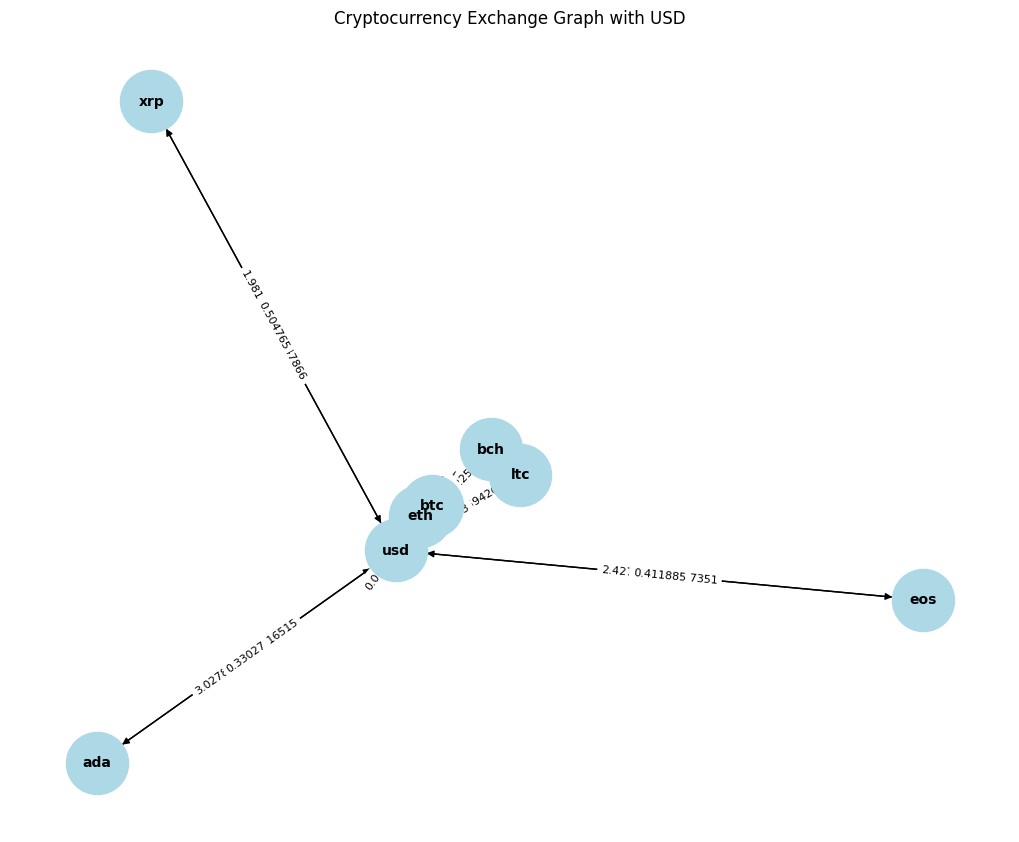

In [49]:
# Graph Visualization
def visualize_graph(g):
    pos = nx.spring_layout(g)
    plt.figure(figsize=(10, 8))
    nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Cryptocurrency Exchange Graph with USD")
    plt.show()

visualize_graph(graph)


### Output Explanation

#### Graph Edges
Shows connections between USD and each cryptocurrency, labeled with weights (exchange rates). For example:
- `('usd', 'btc', {'weight': 1.4584913365614608e-05})` means 1 USD equals ~0.000014585 BTC.
- `('btc', 'usd', {'weight': 68564.0})` means 1 BTC equals 68564 USD.

#### Forward and Reverse Paths with Factors
Each Forward Path shows a route from USD to a cryptocurrency, while the Reverse Path is the opposite direction. The Factor indicates if there’s an arbitrage opportunity. A factor of 1.0 means no arbitrage (equal values forward and reverse).

Example:
- `Forward Path: ['usd', 'btc'] -> Reverse Path: ['btc', 'usd'] | Factor: 1.00000000`

#### Smallest and Greatest Path Weight Factors
These summarize the closest values to potential arbitrage:
- **Smallest Factor**: `0.9999999999999999` with path `( ['btc', 'usd', 'ada'], ['ada', 'usd', 'btc'] )`
- **Greatest Factor**: `1.0000000000000002` with path `( ['bch', 'usd', 'eth'], ['eth', 'usd', 'bch'] )`

### Summary
- **Graph Edges**: Show USD to crypto exchange rates.
- **Paths and Factors**: All factors are 1.0, indicating no arbitrage.
- **Smallest & Greatest Factors**: Show equilibrium with no arbitrage opportunities.
